In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader, Dataset
import numpy as np

from tqdm import tqdm, trange

import matplotlib.pyplot as plt

import os
import librosa
from torchmetrics.audio import SignalDistortionRatio

import torchsummary

In [2]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [32]:

# Define custom dataset
class SpeechDataset(Dataset):
    def __init__(self, noisy_waveforms, clean_waveforms):

        noisy_waveforms = [torch.tensor(np.pad(noisy_waveform.numpy()[:, :500], ((0, 0), (0, 500 - min(500, len(noisy_waveform[0])))))) for noisy_waveform in noisy_waveforms]
        clean_waveforms = [torch.tensor(np.pad(clean_waveform.numpy()[:, :500], ((0, 0), (0, 500 - min(500, len(clean_waveform[0])))))) for clean_waveform in clean_waveforms]

        self.noisy_waveforms = torch.stack(noisy_waveforms, dim=0)
        self.clean_waveforms = torch.stack(clean_waveforms, dim=0)

        # self.noisy_waveforms = torch.tensor(noisy_waveforms)
        # self.clean_waveforms = torch.tensor(clean_waveforms)

    def __len__(self):
        return len(self.noisy_waveforms)

    def __getitem__(self, idx):
        try:
            return torch.Tensor(self.noisy_waveforms[idx]), torch.Tensor(self.clean_waveforms[idx])
        
        except RuntimeError:
            print('Error in index:', idx)
            return torch.Tensor(self.noisy_waveforms[0]), torch.Tensor(self.clean_waveforms[0])


In [5]:
def load_dataset(path):
    data = []

    for i in tqdm(os.listdir(path)):
        waveform, sample_rate = torchaudio.load(os.path.join(path, i), frame_offset=20_000, num_frames=100_000)

        data.append(torchaudio.transforms.MelSpectrogram(sample_rate=10000)(waveform).squeeze())

    return data

In [6]:
noisy_train = load_dataset('../data/uk/noisy_trainset_28spk_wav')

  0%|          | 0/11572 [00:00<?, ?it/s]/Users/polaris000/Library/Python/3.9/lib/python/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
100%|██████████| 11572/11572 [00:28<00:00, 403.70it/s]


In [7]:
clean_train = load_dataset('../data/uk/clean_trainset_28spk_wav')

100%|██████████| 11572/11572 [00:36<00:00, 316.67it/s]


In [8]:
noisy_train = noisy_train[:1000]
clean_train = clean_train[:1000]

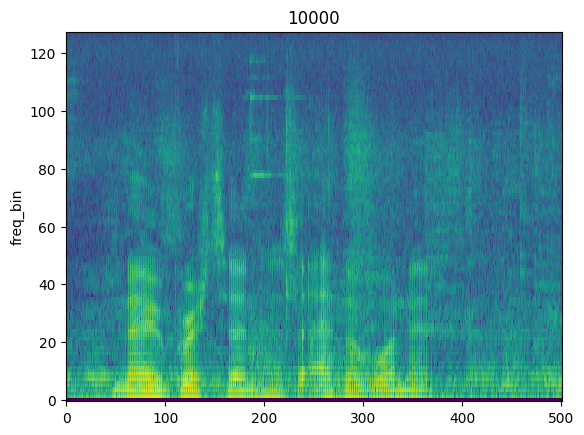

In [ ]:
plot_spectrogram(noisy_train[0])

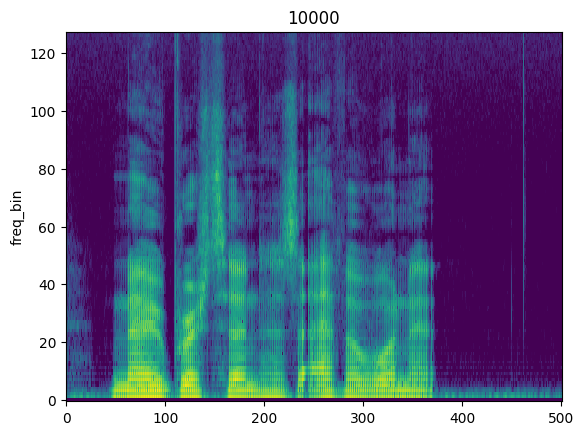

In [34]:
plot_spectrogram(clean_train[0])

In [33]:
# Create dataset and dataloader
dataset = SpeechDataset(noisy_train, clean_train)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [73]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
    
        self.conv1 = nn.Conv2d(1, 18, kernel_size=(9, 7), stride=1, padding=(4, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(18)

        self.conv2 = nn.Conv2d(18, 30, kernel_size=(5, 1), stride=1, padding=(2, 0), bias=False)
        self.bn2 = nn.BatchNorm2d(30)

        self.conv3 = nn.Conv2d(30, 8, kernel_size=(9, 1), stride=1, padding=(4, 0), bias=False)
        self.bn3 = nn.BatchNorm2d(8)

        self.conv4 = nn.Conv2d(8, 18, kernel_size=(9, 1), stride=1, padding=(4, 0), bias=False)
        self.bn4 = nn.BatchNorm2d(18)

        self.conv5 = nn.Conv2d(18, 30, kernel_size=(5, 1), stride=1, padding=(2, 0), bias=False)
        self.bn5 = nn.BatchNorm2d(30)

        self.conv6 = nn.Conv2d(30, 8, kernel_size=(9, 1), stride=1, padding=(4, 0), bias=False)
        self.bn6 = nn.BatchNorm2d(8)

        self.conv7 = nn.Conv2d(8, 18, kernel_size=(9, 1), stride=1, padding=(4, 0), bias=False)
        self.bn7 = nn.BatchNorm2d(18)

        self.conv8 = nn.Conv2d(18, 30, kernel_size=(5, 1), stride=1, padding=(2, 0), bias=False)
        self.bn8 = nn.BatchNorm2d(30)

        self.conv9 = nn.Conv2d(30, 8, kernel_size=(9, 1), stride=1, padding=(4, 0), bias=False)
        self.bn9 = nn.BatchNorm2d(8)

        self.conv10 = nn.Conv2d(8, 18, kernel_size=(9, 1), stride=1, padding=(4, 0), bias=False)
        self.bn10 = nn.BatchNorm2d(18)

        self.conv11 = nn.Conv2d(18, 30, kernel_size=(5, 1), stride=1, padding=(2, 0), bias=False)
        self.bn11 = nn.BatchNorm2d(30)

        self.conv12 = nn.Conv2d(30, 8, kernel_size=(9, 1), stride=1, padding=(4, 0), bias=False)
        self.bn12 = nn.BatchNorm2d(8)

        self.dropout = nn.Dropout2d(0.2)

        self.conv13 = nn.Conv2d(8, 1, kernel_size=(501, 1), stride=1, padding=(250, 0))

    #     # Initialize weights
    #     self.init_weights(l2_strength)

    # def init_weights(self, l2_strength):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d):
    #             nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    #             if m.bias is not None:
    #                 nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.BatchNorm2d):
    #             nn.init.constant_(m.weight, 1)
    #             nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.bn1(x)

        skip0 = self.conv2(x)
        x = nn.ReLU()(skip0)
        x = self.bn2(x)

        x = self.conv3(x)
        x = nn.ReLU()(x)
        x = self.bn3(x)

        x = self.conv4(x)
        x = nn.ReLU()(x)
        x = self.bn4(x)

        skip1 = self.conv5(x)
        x = nn.ReLU()(skip1)
        x = self.bn5(x)

        x = self.conv6(x)
        x = nn.ReLU()(x)
        x = self.bn6(x)

        x = self.conv7(x)
        x = nn.ReLU()(x)
        x = self.bn7(x)

        x = self.conv8(x)
        x = nn.ReLU()(x)
        x = self.bn8(x)

        x = self.conv9(x)
        x = nn.ReLU()(x)
        x = self.bn9(x)

        x = self.conv10(x)
        x = nn.ReLU()(x)
        x = self.bn10(x)

        x = self.conv11(x)
        x = x + skip1
        x = nn.ReLU()(x)
        x = self.bn11(x)

        x = self.conv12(x)
        x = nn.ReLU()(x)
        x = self.bn12(x)

        x = self.conv13(x)

        return x

In [74]:
model = Model().to("cpu")
torchsummary.summary(model, (1, 128, 500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 18, 128, 500]           1,134
       BatchNorm2d-2         [-1, 18, 128, 500]              36
            Conv2d-3         [-1, 30, 128, 500]           2,700
       BatchNorm2d-4         [-1, 30, 128, 500]              60
            Conv2d-5          [-1, 8, 128, 500]           2,160
       BatchNorm2d-6          [-1, 8, 128, 500]              16
            Conv2d-7         [-1, 18, 128, 500]           1,296
       BatchNorm2d-8         [-1, 18, 128, 500]              36
            Conv2d-9         [-1, 30, 128, 500]           2,700
      BatchNorm2d-10         [-1, 30, 128, 500]              60
           Conv2d-11          [-1, 8, 128, 500]           2,160
      BatchNorm2d-12          [-1, 8, 128, 500]              16
           Conv2d-13         [-1, 18, 128, 500]           1,296
      BatchNorm2d-14         [-1, 18, 1

In [76]:
model = Model().to("mps")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 40
losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in tqdm(train_loader):
        noisy, clean = data
        noisy = noisy.to("mps").unsqueeze(1)
        clean = clean.to("mps").unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(noisy)
        loss = criterion(outputs, clean)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    losses.append(running_loss/len(train_loader))
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:49<00:00,  5.08it/s]


Epoch 1/40, Loss: 120.31101601409912


100%|██████████| 250/250 [00:45<00:00,  5.45it/s]


Epoch 2/40, Loss: 91.20696575164794


100%|██████████| 250/250 [00:48<00:00,  5.19it/s]


Epoch 3/40, Loss: 75.07159623336791


100%|██████████| 250/250 [00:59<00:00,  4.22it/s]


Epoch 4/40, Loss: 62.8355357170105


100%|██████████| 250/250 [01:05<00:00,  3.83it/s]


Epoch 5/40, Loss: 53.07152597427368


100%|██████████| 250/250 [01:02<00:00,  3.98it/s]


Epoch 6/40, Loss: 45.32237967300415


100%|██████████| 250/250 [01:02<00:00,  3.98it/s]


Epoch 7/40, Loss: 38.73765944290161


100%|██████████| 250/250 [01:02<00:00,  4.02it/s]


Epoch 8/40, Loss: 34.70493869972229


100%|██████████| 250/250 [00:59<00:00,  4.20it/s]


Epoch 9/40, Loss: 30.81903161239624


100%|██████████| 250/250 [01:05<00:00,  3.83it/s]


Epoch 10/40, Loss: 26.96058494567871


100%|██████████| 250/250 [01:05<00:00,  3.79it/s]


Epoch 11/40, Loss: 24.709345170974732


100%|██████████| 250/250 [01:00<00:00,  4.15it/s]


Epoch 12/40, Loss: 23.605471437454224


100%|██████████| 250/250 [01:02<00:00,  4.01it/s]


Epoch 13/40, Loss: 21.459357889175415


100%|██████████| 250/250 [01:10<00:00,  3.55it/s]


Epoch 14/40, Loss: 20.39916976737976


100%|██████████| 250/250 [01:10<00:00,  3.57it/s]


Epoch 15/40, Loss: 18.92307726287842


100%|██████████| 250/250 [01:04<00:00,  3.88it/s]


Epoch 16/40, Loss: 18.65193476486206


100%|██████████| 250/250 [01:17<00:00,  3.22it/s]


Epoch 17/40, Loss: 17.666762342453


100%|██████████| 250/250 [01:09<00:00,  3.61it/s]


Epoch 18/40, Loss: 17.53160724544525


100%|██████████| 250/250 [01:13<00:00,  3.40it/s]


Epoch 19/40, Loss: 16.762871490478517


100%|██████████| 250/250 [01:08<00:00,  3.63it/s]


Epoch 20/40, Loss: 16.546048687934874


100%|██████████| 250/250 [01:04<00:00,  3.88it/s]


Epoch 21/40, Loss: 16.172145033836365


100%|██████████| 250/250 [01:03<00:00,  3.94it/s]


Epoch 22/40, Loss: 16.1579911403656


100%|██████████| 250/250 [01:04<00:00,  3.88it/s]


Epoch 23/40, Loss: 15.781495109558106


100%|██████████| 250/250 [01:06<00:00,  3.78it/s]


Epoch 24/40, Loss: 15.757237073898315


100%|██████████| 250/250 [01:06<00:00,  3.79it/s]


Epoch 25/40, Loss: 15.11143197441101


100%|██████████| 250/250 [01:03<00:00,  3.94it/s]


Epoch 26/40, Loss: 15.110925037384034


100%|██████████| 250/250 [01:13<00:00,  3.41it/s]


Epoch 27/40, Loss: 15.51069215774536


100%|██████████| 250/250 [01:26<00:00,  2.88it/s]


Epoch 28/40, Loss: 14.305528406143189


100%|██████████| 250/250 [01:32<00:00,  2.70it/s]


Epoch 29/40, Loss: 15.258268977165223


100%|██████████| 250/250 [01:18<00:00,  3.19it/s]


Epoch 30/40, Loss: 14.606896825790406


100%|██████████| 250/250 [01:12<00:00,  3.47it/s]


Epoch 31/40, Loss: 13.969534276008606


100%|██████████| 250/250 [01:12<00:00,  3.47it/s]


Epoch 32/40, Loss: 14.171579545021057


100%|██████████| 250/250 [01:19<00:00,  3.13it/s]


Epoch 33/40, Loss: 14.228741678237915


100%|██████████| 250/250 [01:03<00:00,  3.94it/s]


Epoch 34/40, Loss: 13.852927327156067


100%|██████████| 250/250 [01:01<00:00,  4.06it/s]


Epoch 35/40, Loss: 13.470427406311035


100%|██████████| 250/250 [01:00<00:00,  4.10it/s]


Epoch 36/40, Loss: 13.553128209114075


100%|██████████| 250/250 [01:02<00:00,  4.00it/s]


Epoch 37/40, Loss: 13.884159148216247


100%|██████████| 250/250 [01:03<00:00,  3.95it/s]


Epoch 38/40, Loss: 13.644502650260925


100%|██████████| 250/250 [01:14<00:00,  3.35it/s]


Epoch 39/40, Loss: 13.103861702919007


100%|██████████| 250/250 [01:09<00:00,  3.60it/s]


Epoch 40/40, Loss: 13.160303928375244


In [77]:
torch.save(model.state_dict(), '../models/autoencoder_2d_40_20_120_0.0001.pth')

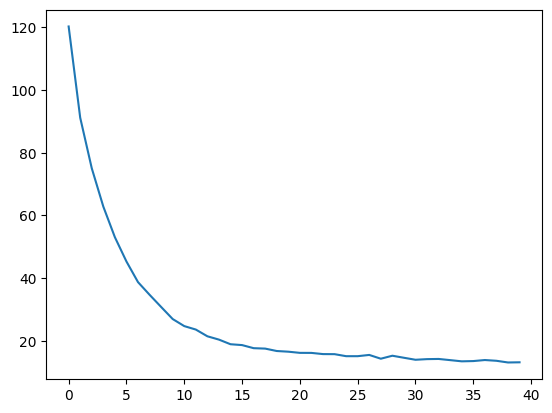

In [78]:
plt.plot(losses)

In [83]:

# Denoise a sample waveform
sample_noisy_waveform = noisy_train[0].unsqueeze(0).unsqueeze(0).to("mps")  # Add batch and channel dimensions
denoised_waveform = model(sample_noisy_waveform)


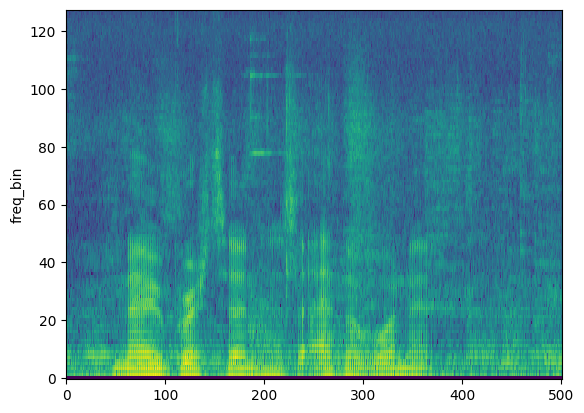

In [108]:
plot_spectrogram(noisy_train[0])

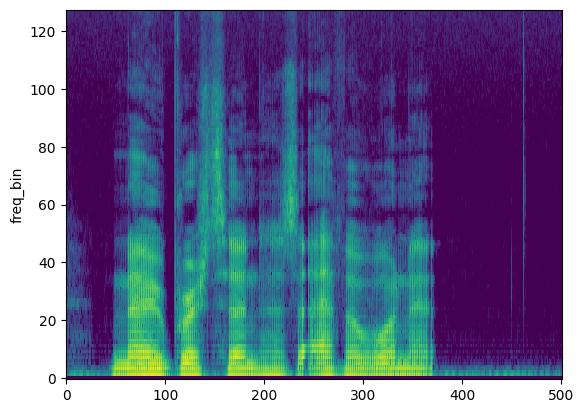

In [109]:
plot_spectrogram(clean_train[0])

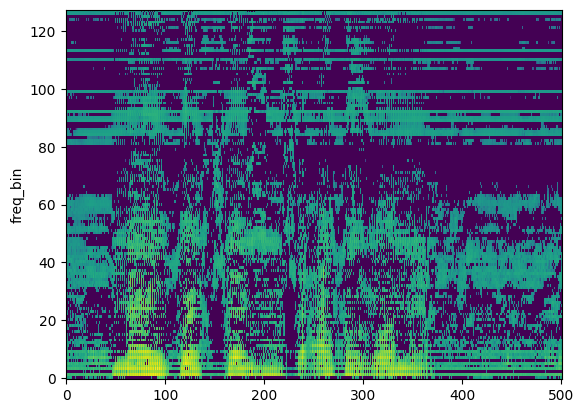

In [111]:
plot_spectrogram(denoised_waveform.to("cpu").squeeze().detach())

In [114]:
SignalDistortionRatio()(denoised_waveform.to("cpu").squeeze().flatten().unsqueeze(0), clean_train[0].to("cpu").flatten().unsqueeze(0))

tensor(14.7775, grad_fn=<SqueezeBackward0>)

In [ ]:
sdr_scores = []

for i in trange(len(noisy_train)):
    sample_noisy_waveform = noisy_train[i].unsqueeze(0).unsqueeze(0).to("mps")  # Add batch and channel dimensions
    denoised_waveform = model(sample_noisy_waveform)

    # clean_inv = torchaudio.transforms.InverseMelScale(400)(clean_train[i])

    sdr_scores.append(SignalDistortionRatio()(denoised_waveform.to("cpu").squeeze().flatten().unsqueeze(0), clean_train[i].to("cpu").flatten().unsqueeze(0)))

In [130]:
torch.mean(torch.tensor(sdr_scores))

tensor(13.7736)